In [2]:
import numpy as np
import matplotlib.pyplot as plt

import double_lattice_current

# Double current lattice demo
We have some transmission lines in series with
$$ Z_0 = 50 [Ohm]$$
$$ Z_1 = 70 [Ohm]$$

and a time delay of
$$ TD0 = 250 [ps] $$
$$ TD1 = 150 [ps] $$

The driver has a resitance of
$$ r_s = 25 [Ohm] $$

and a swing of
$$ v_s = 0 \rightarrow 2 V$$

and the lines are terminated with
$$ r_t = 12.5 [Ohm] $$

We denote the driver side af near end and termination side as far end.

Now we e.g. have a pair of lines, that are open, with a switch near the far end ground. Then initially near, central and far ends must be high. We can model this by considering the current instead of voltage and going backwards. By that I mean to swap the order of the two lines, when inserting into the function, as the current rises from the far end and goes towards the near end.

In [3]:
z0 = 50
z1 = 70

td0 = 250*1e-12  # [s]
td1 = 150*1e-12

r_s = 25  # [Ohm] meaning it's overdriven, which results in a nice and clear 'ringing' effect
v_s = 2  # [V]

r_t  = 12.5

In this case we have to consider multiple back and forth reflection and transmission these have the values of

Reflections:
$$\rho _ 1 = \frac{R_s - Z_{01}}{R_s + Z_{01}} $$
$$\rho _ 2 = \frac{Z_{02} - Z_{01}}{Z_{01} + Z_{02}} $$
$$\rho _ 3 = \frac{Z_{01} - Z_{02}}{Z_{01}+ Z_{02}} $$
$$\rho _ 4 = \frac{R_t - Z_{02}}{R_t+ Z_{02}} $$

Transmissions:
$$T_2 = 1 + \rho_2 $$
$$T_3 = 1 + \rho_3 $$

Now, the rest is a running a normal lattice, with taking  care of these additional reflections and transmissions.

To run this, I've come up with an algorithm, of handling outgoing waves in a list. A wave going into the A surface, would be denoted
$$v_i = (time=t, (v_a, 0, 0, 0))$$
it would then be reflected and send into B as

$$ v_{i+1} = (time=t + timedelay_0, (0, v_a\cdot\rho_a, 0, 0)) $$

and the near end value would be updated with the in and outgoing waves as

$$Near_{i} = Near_{i-1} + v_a \cdot (1 + \rho_a). $$

In each iteration, we update the timestamp as $time_i = time_{i-1} + timedelay(medium)$. This is to keep track of events in chronological order. After all of this is done, we enter the wave into a priority queue.

The interesting part comes, when a wave goes into a transitory interface such as B or C. Here we update the beam as going through to A or D, but also generate a new wave that has been reflected going to the other side.

In the case of B, that would look like:
$$ (time=t, (0, v_b, 0, 0)) \rightarrow \begin{cases} (time=t + timedelay_1, (0, 0, 0, T_b\cdot v_b))\\
(time=t + timedelay_0, (v_b\cdot\rho_b, 0, 0, 0)) \end{cases} $$

Both of these events are then inserted into the priority queue, from which we draw the next event with the lowest timestamp. If we ever draw a wave, where the amplitude is less than some tolerance of the steady state, we remove it.

In [4]:
near_end_I, central_I, far_end_I = double_lattice_current.run_diagram(v_source=v_s, time_delays_tuple = (td1, td0), line_impedances_tuple = (z1, z0), r_source=r_t, r_termination=r_s)

Reflection coefficients:
	rho_abcd = (-0.696969696969697, -0.16666666666666666, 0.16666666666666666, -0.3333333333333333).
Initial current:
	i_initial = 0.0533 [A]


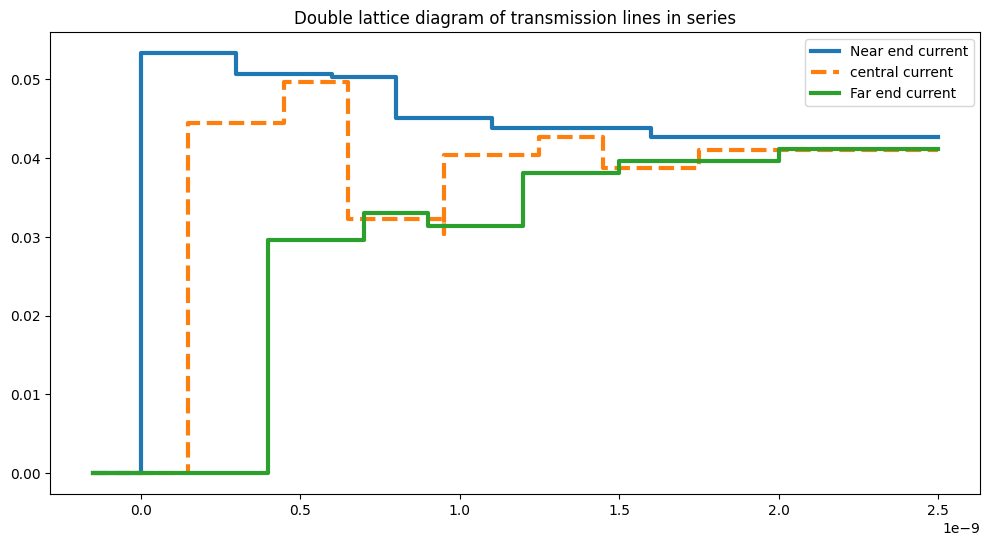

In [6]:
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.set_title('Double lattice diagram of transmission lines in series')
ax.plot(near_end_I[0], near_end_I[1], label='Near end current', linewidth=3)
ax.plot(central_I[0], central_I[1], '--', label='central current', linewidth=3)
ax.plot(far_end_I[0], far_end_I[1], label='Far end current', linewidth=3)
ax.legend()

plt.legend()
plt.show()

To make this usable we now turn all of these current values into voltage as:
$$V_{level} = V_{source} - I(t)*(R_s + R_t) $$

In [8]:
near_end_V = [near_end_I[0],[v_s  - i*(r_s + r_s) for i in near_end_I[1]]]
central_V = [central_I[0],[v_s  - i*(r_s + r_s) for i in central_I[1]]]
far_end_V = [far_end_I[0],[v_s  - i*(r_s + r_s) for i in far_end_I[1]]]

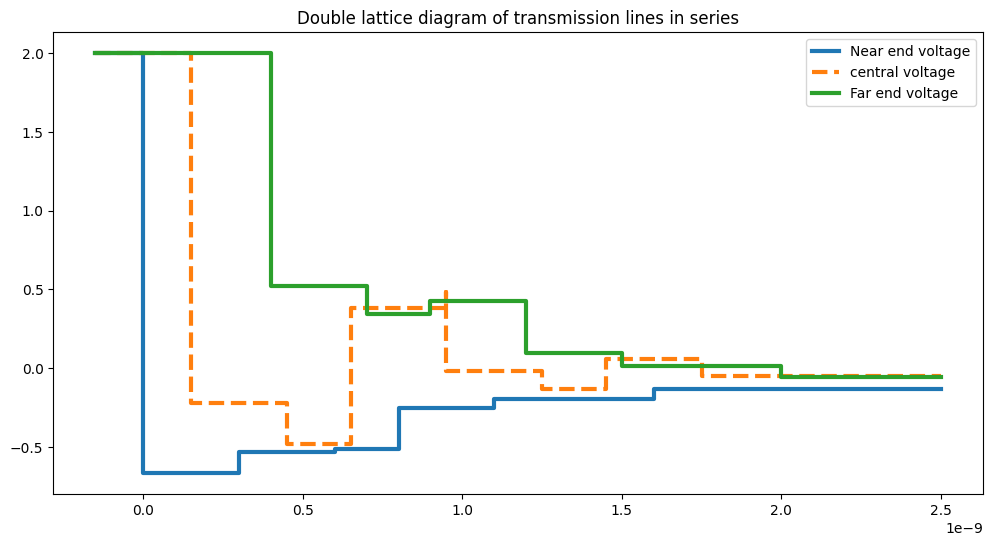

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 6))

ax.set_title('Double lattice diagram of transmission lines in series')
ax.plot(near_end_V[0], near_end_V[1], label='Near end voltage', linewidth=3)
ax.plot(central_V[0], central_V[1], '--', label='central voltage', linewidth=3)
ax.plot(far_end_V[0], far_end_V[1], label='Far end voltage', linewidth=3)
ax.legend()

plt.legend()
plt.show()